# Import Library

In [1]:
import itk 
from itkwidgets import view

In [2]:
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage
from aicsimageio.writers.ome_tiff_writer import OmeTiffWriter

# function for core algorithm
from aicssegmentation.core.seg_dot import dot_3d, dot_3d_wrapper, dot_2d_slice_by_slice_wrapper
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_slice_by_slice
from skimage.morphology import remove_small_objects, binary_closing, watershed, dilation, erosion, ball     # function for post-processing (size filter)
from skimage.feature import peak_local_max
from skimage.measure import label
from scipy.ndimage.morphology import binary_fill_holes
from scipy.ndimage import distance_transform_edt

# Image preview

## Using itkwidgets

In [3]:
%ls

 Volume in drive C has no label.
 Volume Serial Number is BA7C-7AF7

 Directory of C:\Shared\RNA-labeling-quantification\RNA-count\count_python

05/19/2020  09:40 AM    <DIR>          .
05/19/2020  09:40 AM    <DIR>          ..
05/11/2020  05:35 PM    <DIR>          .ipynb_checkpoints
05/12/2020  02:52 PM    <DIR>          aicssegmentation
05/12/2020  01:58 PM    <DIR>          aics-segmentation
05/06/2020  12:07 PM        14,785,354 c1.tif
05/06/2020  12:07 PM        14,785,354 c2.tif
05/06/2020  12:08 PM        14,785,354 c3.tif
03/03/2020  03:59 PM        47,208,686 uc-stem-2x2-005-Aligned-Focused Images.tif
05/19/2020  09:40 AM           191,247 Visualization.ipynb
               5 File(s)     91,755,995 bytes
               5 Dir(s)  204,843,380,736 bytes free


In [9]:
file_name = 'uc-stem-2x2-005-Aligned-Focused Images.tif'
image = itk.imread(file_name)
view(image)

Viewer(rendered_image=<itkImagePython.itkImageUS3; proxy of <Swig Object of type 'itkImageUS3 *' at 0x00000247…

In [10]:
print(image.shape)

(3, 2220, 2220)


## Using AICSImage

AICSImage takes microscopy image data types (files) of varying dimensions (“ZYX”, “TCZYX”, “CYX”) and puts them into a consistent 6D “STCZYX” ordered dask array. The data, metadata are lazy loaded and can be accessed as needed. Note the dims are assumed to match “STCZYX” from right to left meaning if dimensional data is provided then the dimensions are assigned to be “CZYX”, 2 dimensional would be “YX”. 

Scene, Time, Channel, Z, Y, and X

In [11]:
reader = AICSImage(file_name)
IMG = reader.get_image_data("CZYX", S=0, T=0)

print(IMG.shape)

(3, 1, 2220, 2220)


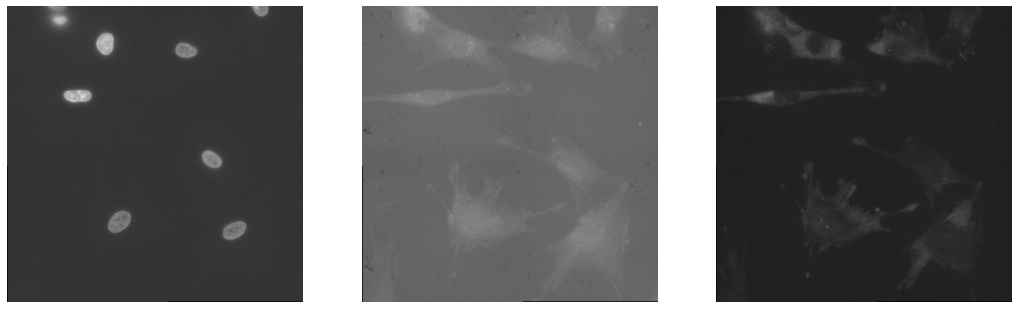

In [12]:
N_CHANNELS = IMG.shape[0]

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS>1:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[channel,0,:,:], cmap=plt.cm.gray)
else:
    ax.axis('off')
    ax.imshow(IMG[0,0,MID_SLICE,:,:], cmap=plt.cm.gray)

In [13]:
# Specify the channel to visualize
#####################
structure_channel = 1
#####################

struct_img0 = IMG[structure_channel,:,:,:].copy()
view(single_fluorescent_view(struct_img0))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x0000024771…

# Image segmentation

## Step 1: Pre-Processing

About selected algorithms and tuned parameters

* **Intensity normalization**: Parameter `intensity_scaling_param` has two options: two values, say `[A, B]`, or single value, say `[K]`. For the first case, `A` and `B` are non-negative values indicating that the full intensity range of the stack will first be cut-off into **[mean - A * std, mean + B * std]** and then rescaled to **[0, 1]**. The smaller the values of `A` and `B` are, the higher the contrast will be. For the second case, `K`>0 indicates min-max Normalization with an absolute intensity upper bound `K` (i.e., anything above `K` will be chopped off and reset as the minimum intensity of the stack) and `K`=0 means min-max Normalization without any intensity bound.

    * `intensity_scaling_param = [3.5, 15]`


* **Smoothing** 

    * `gaussian_smoothing_sigma = 1`. The large the value is, the more the image will be smoothed. 

In [14]:
################################
## PARAMETERS for this step ##
intensity_scaling_param = [3, 8]
gaussian_smoothing_sigma = 1
################################
# intensity normalization
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)

# smoothing with 2d gaussian filter slice by slice 
structure_img_smooth = image_smoothing_gaussian_slice_by_slice(struct_img, sigma=gaussian_smoothing_sigma)

intensity normalization: normalize into [mean - 3 x std, mean + 8 x std] 
intensity normalization completes


In [15]:
view(single_fluorescent_view(structure_img_smooth))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x0000024774…

### Get suggestion for color normalization

If the image is not satisfactory, use the suggest value from the library by running the code below

In [16]:
from aicssegmentation.core.pre_processing_utils import suggest_normalization_param
suggest_normalization_param(struct_img0)

mean intensity of the stack: 1092.6549174174174
the standard deviation of intensity of the stack: 88.65121267180977
0.9999 percentile of the stack intensity is: 1787.0
minimum intensity of the stack: 791
maximum intensity of the stack: 1890
suggested upper range is 8.0, which is 1801.8646187918957
suggested lower range is 3.0, which is 826.7012794019881
So, suggested parameter for normalization is [3.0, 8.0]
To further enhance the contrast: You may increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions)
To slightly reduce the contrast: You may decrease the first value, or increase the second value


## Core algorithm

### step 2.1: Masked-Object (MO) Thresholding

The basic idea of MO thresholding is to apply a relatively low global threshold to roughly mask out each individual object, and then apply a relatively high threshold within each object. This is meant to handle intensity variation from cell to cell. In general, triangle method and median method are two thresholding algorithms usually yield relatively low threshold. Otsu is used within each object for the relatively high threshold. 

There are two parameters:
* `global_thresh_method`: Support `'tri'`, `'med'`,`'ave'` in current version. `'tri'` is triangle method, `'med'` is median method, `'ave'` is the average of the values returned by triangle method and median method.
* `object_minArea`: The minimal area of connected components after global thresholding to be considered as valid objects. Due to some background noise there could be some small connected components in the global thresholding result. Doing Otsu thresholding within such regions will certainly result in errors. So, we want remove them before doing thresholding within each object.  


Parameter for NPM1:  `global_thresh_method='ave'` and `object_minArea=700`

In [17]:
bw_high, bw_low = MO(structure_img_smooth, global_thresh_method='ave', object_minArea=700, return_object=True)

In [32]:
# # view the segmentation result for high threshold
# viewer_bw_high = view(segmentation_quick_view(bw_high))
# viewer_bw_high

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x000001A5…

In [ ]:
# # View ROI compared with original picture
# view(seg_fluo_side_by_side(struct_img,bw_high,roi=['ROI',viewer_bw_high.roi_slice()]))


In [18]:
# view the segmentation result for low threshold
viewer_bw_low = view(segmentation_quick_view(bw_low))
viewer_bw_low

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x00000247…

In [19]:
# View ROI compared with original picture
view(seg_fluo_side_by_side(struct_img,bw_low,roi=['ROI',viewer_bw_low.roi_slice()]))


Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x0000024703…

### If the above segmentation is satisfactory? Here are some possible things to check:
* Is there big missing chunk? Or are segmented chunks are significantly fatter? You may visualize the intermediate result, i.e. the objects, by `view(segmentation_quick_view(bw_low))`. By doing this, you can have some sense whether the objects are roughly regions in individual cells. In other words, we want to roughly isolate the stuffs in individual cells. If not, you may change `global_thresh_method`. Three options `'tri'`, `'med'`,`'ave'` are implemented. `'tri'` is triangle method, `'med'` is median method, `'ave'` is the average of the values returned by triangle method and median method. 
* Observing missing chunks may be also due to falsely removed objects. Try to decrease `object_minArea` to be more permisive in segmenting objects.
* Do you observe a chunk of background stuffs in the segmentation? Try to increase `object_minArea` to exclude these background noise. 
* If you observe the segmented objects are slightly fatter than the actual size (may take defraction of light into consideration), don't worry, Next step (2.2) can help the make them thinner. 
* If you observe missing dots in the segmentation, don't worry. Later step (2.3) can pick them up.


### Step 3: Post-Processing 


In [22]:
################################
## PARAMETERS for this step ##
minArea = 10
################################

seg = remove_small_objects(bw_low>0, min_size=minArea, connectivity=1, in_place=False)

In [23]:
view(seg_fluo_side_by_side(struct_img, seg))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x0000024772…

### Image segmentation

In [27]:
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max


In [28]:
image = np.squeeze(seg)

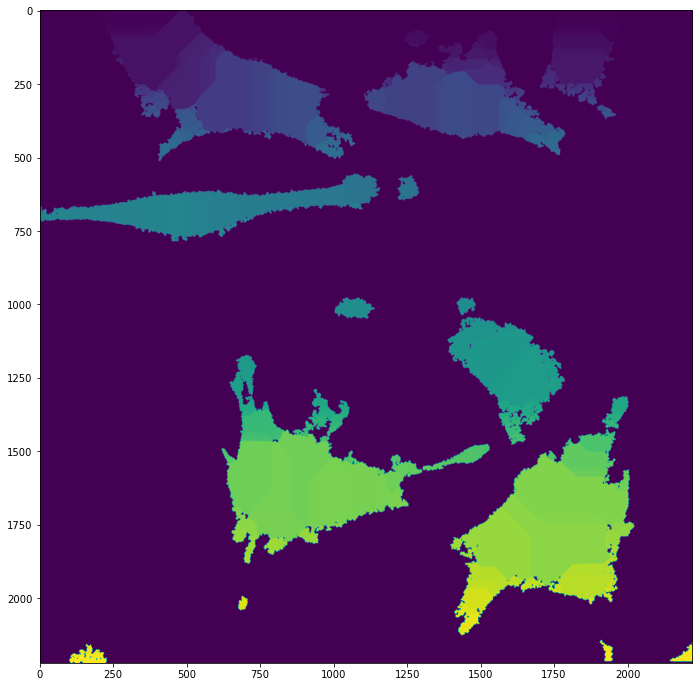

In [30]:
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

# fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
# ax = axes.ravel()

# ax[0].imshow(image, cmap=plt.cm.gray)
# ax[0].set_title('Overlapping objects')
# ax[1].imshow(-distance, cmap=plt.cm.gray)
# ax[1].set_title('Distances')
# ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
# ax[2].set_title('Separated objects')

# for a in ax:
#     a.set_axis_off()

# fig.tight_layout()

plt.imshow(labels)

### step 4: Apply 2D spot filter

Parameter syntax: `[[scale_1, cutoff_1], [scale_2, cutoff_2], ....]` 
* `scale_x` is set based on the estimated radius of your target dots. For example, if visually the diameter of the dots is usually 3~4 pixels, then you may want to set `scale_x` as `1` or something near `1` (like `1.25`). Multiple scales can be used, if you have dots of very different sizes.  
* `cutoff_x` is a threshold applied on the actual filter reponse to get the binary result. Smaller `cutoff_x` may yielf more dots and fatter segmentation, while larger `cutoff_x` could be less permisive and yield less dots and slimmer segmentation. 

We want to apply S2 filter in two ways: one on the original image to detect extra bright spots, and another one on the inverse of the original image to detect dark spots to remove

Parameter for extra bright spots:  `s2_param_bright = [[2, 0.025]]`
Parameter for dark spots:  `s2_param_dark = [[2, 0.025], [1, 0.025]]`

In [36]:
######
s2_param_bright = [[2, 0.025]]
s2_param_dark = [[2, 0.025], [1, 0.025]]
######

bw_extra = dot_2d_slice_by_slice_wrapper(structure_img_smooth, s2_param_bright)
bw_dark = dot_2d_slice_by_slice_wrapper(1-structure_img_smooth, s2_param_dark)

In [37]:
view(segmentation_quick_view(bw_extra))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x000001A5…